# HW1 - Hacker extra - Gradient Boosting

Since my models were so abyssmal I thought I would try some boosting ;) 

## Preliminaries

In [1]:
# To auto-reload modules in jupyter notebook (so that changes in files *.py doesn't require manual reloading):
# https://stackoverflow.com/questions/5364050/reloading-submodules-in-ipython
%load_ext autoreload
%autoreload 2

Import commonly used libraries and magic command for inline plotting

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image


In [2]:
%matplotlib inline

## Preprocessing

Let's try out the Histogram-based Gradient Boosting Classification Tree

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# explicitly require this experimental feature
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
# now you can import normally from ensemble
from sklearn.ensemble import HistGradientBoostingClassifier

# Need the following to encode our target variable
from sklearn.preprocessing import OrdinalEncoder

We still need to break the data up into training and test data and numerical & categorical columns, so we will reuse some of the code from our previous attempts with all data...

In [5]:
tax_df = pd.read_csv("./data/raw/TaxInfo.csv")

In [6]:
tax_df['Married'] = tax_df['Married'].apply(str)
tax_df['Filed_2017'] = tax_df['Filed_2017'].apply(str)
tax_df['Filed_2016'] = tax_df['Filed_2017'].apply(str)
tax_df['Filed_2015'] = tax_df['Filed_2017'].apply(str)
print (tax_df.dtypes)


HHI                int64
HHDL               int64
Married           object
CollegGrads        int64
AHHAge             int64
Cars               int64
Filed_2017        object
Filed_2016        object
Filed_2015        object
PoliticalParty    object
dtype: object


In [7]:
# Changing this to reflect we have kept all of the columns this time
X = tax_df.iloc[:, 0:9]
y = tax_df.iloc[:, 9]
X.head()


,HHI,HHDL,Married,CollegGrads,AHHAge,Cars,Filed_2017,Filed_2016,Filed_2015
0,49685,227187,0,0,105,0,1,1,1
1,64756,-507342,2,3,68,3,1,1,1
2,115435,521290,1,3,81,2,0,0,0
3,99454,251829,2,1,52,4,1,1,1
4,157274,-472337,0,1,28,1,1,1,1


In [16]:
y.head()

0       Democrat
1    Independent
2     Republican
3     Republican
4    Independent
Name: PoliticalParty, dtype: object

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
# Partition our data into train and test sets to use for model fitting and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [10]:
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(include=['number']).columns.tolist()

all_cols = X.columns.tolist()


In [11]:
numeric_cols

['HHI', 'HHDL', 'CollegGrads', 'AHHAge', 'Cars']

In [12]:
categorical_cols

['Married', 'Filed_2017', 'Filed_2016', 'Filed_2015']

In [13]:
assert len(all_cols) == len(categorical_cols) + len(numeric_cols), 'each col should either be in categorical or numeric lists'

Ok, now we are caught up and can get to the business of new stuff for this model...

## Gradient Boosting Model 

A little different than last time, since the columns get reordered with the preprocessor.  We won't grab column values until AFTER that step

In [17]:
numeric_transformer_hgbc = StandardScaler()
categorical_transformer_hgbc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
target_transformer_hgbc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)

preprocessor_hgbc = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer_hgbc, categorical_cols),
        ('num', numeric_transformer_hgbc, numeric_cols)],
        remainder='passthrough')

# The preprocessor reorders the columns into blocks by type as defined by the transformers. So, now
# the categorical cols are the first columns. We need their index numbers to use in the call to the
# HistGradientBoostingClassifier() so it knows which cols to treat as categoricals (even though they
# have been transformed into meaningless integers.)


categorical_cols_idx = [_ for _ in range(len(categorical_cols))]



Now we make a pipeline like before

In [19]:
# Append classifier to preprocessing pipeline.
clf_hgbc = Pipeline(steps=[('preprocessor', preprocessor_hgbc),
                      ('classifier', HistGradientBoostingClassifier(categorical_features=categorical_cols_idx))])

# Fit model
clf_hgbc.fit(X_train, y_train)
print(f"hgbc training score: {clf_hgbc.score(X_train, y_train):.3f}")

# And now let's see how it does on the test data
print(f"hgbc training score: {clf_hgbc.score(X_test, y_test):.3f}")

hgbc training score: 1.000
hgbc training score: 0.398


The training score indicates that the model is overfit.  I'm sure there is a way to dial it back like I did with Random Forest attempt.  I actually did better on the test data with my pruned trees from my first attempt where I dropped all of the "Filed_" variables.

Let's do the confusion matrix to see if it is falling short in the same areas...
Train data is overfit, as displayed below:

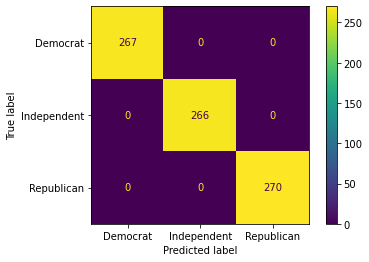

In [20]:
plot_confusion_matrix(clf_hgbc, X_train, y_train, labels=clf_hgbc['classifier'].classes_)

Testing data plays out as follows:

Confusion matrix for test, Gradient Boosting model
[[28 17 24]
 [26 30 15]
 [25 14 22]]
Normalized confusion matrix for test
[[0.4057971  0.24637681 0.34782609]
 [0.36619718 0.42253521 0.21126761]
 [0.40983607 0.2295082  0.36065574]]


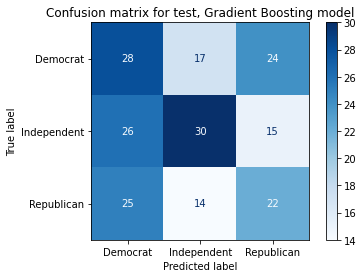

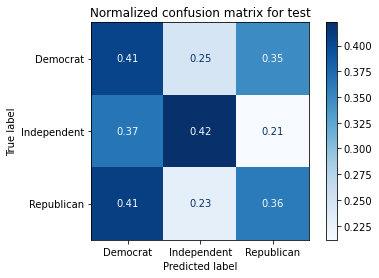

In [22]:
titles_options = [("Confusion matrix for test, Gradient Boosting model", None),
                  ("Normalized confusion matrix for test", 'true')]

class_names = clf_hgbc['classifier'].classes_

for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_hgbc, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

The Gradient Boosting model is predicting 'Independent's a little better than my best previous model, but not doing as well on 'Republican's